# Dataforhåndsbehandling

### Sjekk første fil i datasettet for å hente ut informasjon om generel datastruktur

In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Laste inn .mat filen som en HDF5-fil
file_path = 'C:/Users/simen/Prosjekter/1512427/brainTumorDataset/1.mat'  # Hardkodet som må endres lokalt
hdf5_contents = {}

with h5py.File(file_path, 'r') as file:
    # Gå gjennom hvert element i HDF5-filen
    for key in file.keys():
        # Lese hvert datasett inn i en dictionary
        hdf5_contents[key] = np.array(file[key])

# Viser innholdet i filen
hdf5_contents.keys()


dict_keys(['cjdata'])

In [2]:
# Åpne HDF5-filen og hente ut alle feltene i cjdata
with h5py.File(file_path, 'r') as file:
    # Først henter vi 'cjdata' gruppen
    cjdata_group = file['cjdata']
    
    # Deretter henter vi hvert felt i gruppen
    label = np.array(cjdata_group['label']).squeeze()
    PID = np.array(cjdata_group['PID']).squeeze()
    image = np.array(cjdata_group['image'])
    tumorBorder = np.array(cjdata_group['tumorBorder']).squeeze()
    tumorMask = np.array(cjdata_group['tumorMask']).squeeze()

# Viser informasjon om hvert felt
(label, PID, image.shape, tumorBorder.shape, tumorMask.shape)


(array(1.),
 array([49, 48, 48, 51, 54, 48], dtype=uint16),
 (512, 512),
 (38,),
 (512, 512))

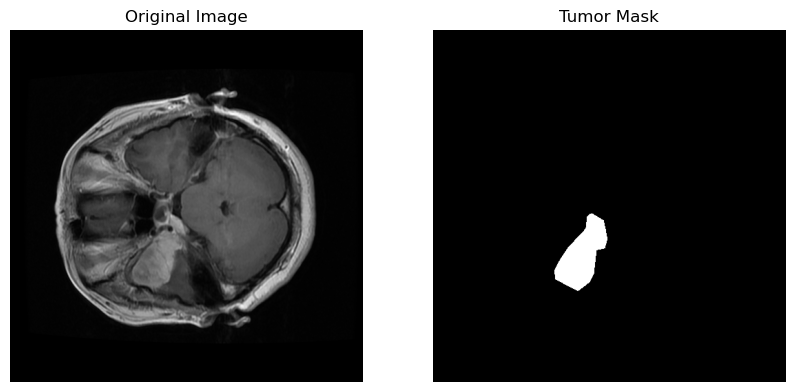

In [3]:
# Visualiserer bildet og tumormasken
plt.figure(figsize=(10, 5))

# Viser bildet
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Viser tumormasken
plt.subplot(1, 2, 2)
plt.imshow(tumorMask, cmap='gray')
plt.title('Tumor Mask')
plt.axis('off')

# Viser plottene
plt.show()


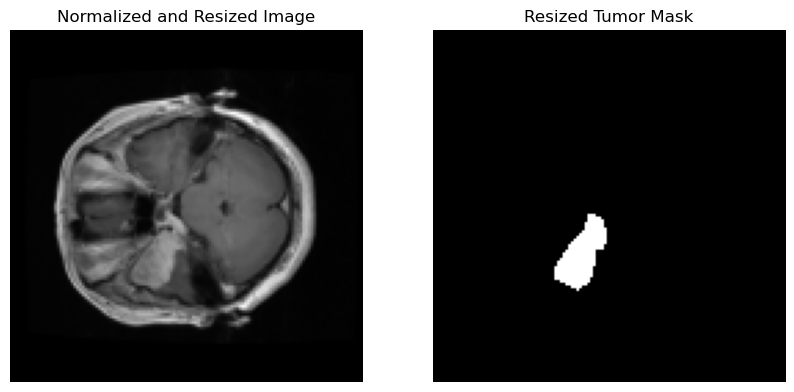

In [4]:
from skimage.transform import resize

# Normaliserer og endrer størrelsen på bildet og masken
def preprocess_image(file_path, img_size=(128, 128)):
    with h5py.File(file_path, 'r') as file:
        cjdata_group = file['cjdata']
        image = np.array(cjdata_group['image'])
        tumorMask = np.array(cjdata_group['tumorMask']).astype(np.bool_)
    
    # Normalisere bildet
    normalized_image = image / np.max(image)
    
    # Endre størrelsen på bildet
    resized_image = resize(normalized_image, img_size, mode='reflect', anti_aliasing=True)
    
    # Endre størrelsen på masken
    resized_tumorMask = resize(tumorMask, img_size, mode='constant', preserve_range=True, anti_aliasing=False)
    resized_tumorMask = resized_tumorMask > 0.5 # Binarize the resized mask

    return resized_image, resized_tumorMask

# Prosesserer det første bildet
resized_image, resized_tumorMask = preprocess_image(file_path)

# Visualiserer det normaliserte og størrelsesendrede bildet og tumormasken
plt.figure(figsize=(10, 5))

# Viser det normaliserte og størrelsesendrede bildet
plt.subplot(1, 2, 1)
plt.imshow(resized_image, cmap='gray')
plt.title('Normalized and Resized Image')
plt.axis('off')

# Viser den størrelsesendrede tumormasken
plt.subplot(1, 2, 2)
plt.imshow(resized_tumorMask, cmap='gray')
plt.title('Resized Tumor Mask')
plt.axis('off')

# Viser plottene
plt.show()


### Prosseser hele datasettet og lag en egen fil til dette

In [5]:
import os
import h5py
import numpy as np
from skimage.transform import resize
from tqdm import tqdm  

def preprocess_and_save_dataset(input_folder, output_file, img_size=(128, 128)):
    with h5py.File(output_file, 'w') as h5file:
        # Lag datasett for bilder, masker og etiketter i HDF5-filen
        images_dataset = h5file.create_dataset('images', shape=(0, img_size[0], img_size[1]), maxshape=(None, img_size[0], img_size[1]), dtype=np.float32)
        masks_dataset = h5file.create_dataset('masks', shape=(0, img_size[0], img_size[1]), maxshape=(None, img_size[0], img_size[1]), dtype=np.uint8)
        labels_dataset = h5file.create_dataset('labels', shape=(0,), maxshape=(None,), dtype=np.uint8)

        # List alle .mat-filer i inndatamappen, unntatt cvind.mat
        mat_files = [f for f in os.listdir(input_folder) if f.endswith('.mat') and f != 'cvind.mat']
        
        # Gå gjennom hver fil og prosesser
        for mat_file in tqdm(mat_files, desc='Processing files'):
            file_path = os.path.join(input_folder, mat_file)
            try:
                with h5py.File(file_path, 'r') as file:
                    cjdata_group = file['cjdata']
                    image = np.array(cjdata_group['image'])
                    tumorMask = np.array(cjdata_group['tumorMask']).astype(np.bool_)
                    label = np.array(cjdata_group['label']).squeeze()

                # Normaliser og endre størrelse på bildet
                normalized_image = image / np.max(image)
                resized_image = resize(normalized_image, img_size, mode='reflect', anti_aliasing=True)

                # Endre størrelse på tumormaske
                resized_tumorMask = resize(tumorMask, img_size, mode='constant', preserve_range=True, anti_aliasing=False)
                resized_tumorMask = (resized_tumorMask > 0.5).astype(np.uint8)

                # Legg til behandlede data til HDF5-datasettene
                images_dataset.resize((images_dataset.shape[0] + 1, img_size[0], img_size[1]))
                images_dataset[-1] = resized_image

                masks_dataset.resize((masks_dataset.shape[0] + 1, img_size[0], img_size[1]))
                masks_dataset[-1] = resized_tumorMask

                labels_dataset.resize((labels_dataset.shape[0] + 1,))
                labels_dataset[-1] = label
            except KeyError as e:
                print(f"KeyError: {e} in file {file_path}. File skipped.")

# Kall funksjonen med sti til datasettet, Dette endres etter behov lokalt 
preprocess_and_save_dataset(input_folder='C:/Users/simen/Prosjekter/1512427/brainTumorDataset', output_file='C:/Users/simen/Prosjekter/preprocessed_dataset.h5')


Processing files: 100%|██████████| 3064/3064 [02:36<00:00, 19.58it/s]


### Sjekke 5-Fold Cross validation filen

In [5]:
def inspect_mat_file_structure(file_path):
    with h5py.File(file_path, 'r') as file:
        print("Keys in the file:", list(file.keys()))

# Sti til cvind.mat-filen
cvind_file_path = 'C:/Users/simen/Prosjekter/1512427/cvind.mat'  # Hardkodet som må endres lokalt

# Inspekter filstrukturen
inspect_mat_file_structure(cvind_file_path)


Keys in the file: ['cvind']


In [6]:

def load_cv_indices(file_path):
    with h5py.File(file_path, 'r') as file:
        # Last inn dataene fra 'cvind' nøkkelen
        cv_indices = np.array(file['cvind'])
    return cv_indices

# Sti til cvind.mat-filen
cvind_file_path = 'C:/Users/simen/Prosjekter/1512427/cvind.mat'  # Hardkodet som må endres lokalt

# Last inn kryssvalideringsindeksene
cv_indices = load_cv_indices(cvind_file_path)

# Skriv ut de første elementene av cv_indices for å få en idé om deres struktur
print(cv_indices[:10])


[[5. 5. 5. ... 4. 2. 1.]]


### Her sjekker vi hvordan dataene er organisert så langt

In [7]:
import h5py
import numpy as np

def load_data(h5_file_path):
    with h5py.File(h5_file_path, 'r') as h5file:
        images = np.array(h5file['images'])
        labels = np.array(h5file['labels'])
    return images, labels

# Last inn bildene og etikettene
h5_file_path = 'C:/Users/simen/Prosjekter/preprocessed_dataset.h5' # Hardkodet som må endres lokalt
images, labels = load_data(h5_file_path)

# Skriv ut formen på bildene og etikettene for å bekrefte
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (3064, 128, 128)
Labels shape: (3064,)


Bildene og etikettene er like mange og størrelsen på bildene er like store

In [8]:
def inspect_h5_file(file_path):
    with h5py.File(file_path, 'r') as h5file:
        print("Keys in the file:", list(h5file.keys()))

# Inspekter HDF5-filen
inspect_h5_file('C:/Users/simen/Prosjekter/preprocessed_dataset.h5') # Hardkodet som må endres lokalt


Keys in the file: ['images', 'labels', 'masks']


Her ser vi at det finnes bilder, etikket til bildene og en Tumor maske til disse bildene 

In [9]:
with h5py.File('C:/Users/simen/Prosjekter/preprocessed_dataset.h5', 'r') as h5file:
    masks = np.array(h5file['masks'])
    print("Masks shape:", masks.shape)


Masks shape: (3064, 128, 128)


Maskene er like mange og har samme størrelse

### Oppdeling i trenings og validerings sett

In [10]:
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Sjekk den nye fordelingen
print("Ny fordeling i treningssettet:", Counter(y_train))
print("Ny fordeling i valideringssettet:", Counter(y_val))


Ny fordeling i treningssettet: Counter({2: 1141, 3: 744, 1: 566})
Ny fordeling i valideringssettet: Counter({2: 285, 3: 186, 1: 142})


# Oppsett av CNN (Modellering)


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # Antall klasser = 3 (meningioma, glioma, pituitary tumor)
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 128)      0

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

history = model.fit(
    X_train, y_train_adjusted,            
    epochs=10,
    validation_data=(X_val, y_val_adjusted)  
)

Epoch 1/10
77/77 [==============================] - 55s 686ms/step - loss: 0.7969 - accuracy: 0.6406 - val_loss: 0.5366 - val_accuracy: 0.7488
Epoch 2/10
77/77 [==============================] - 59s 769ms/step - loss: 0.5545 - accuracy: 0.7495 - val_loss: 0.4027 - val_accuracy: 0.8222
Epoch 3/10
77/77 [==============================] - 55s 708ms/step - loss: 0.4279 - accuracy: 0.8152 - val_loss: 0.3655 - val_accuracy: 0.8157
Epoch 4/10
77/77 [==============================] - 49s 637ms/step - loss: 0.3471 - accuracy: 0.8450 - val_loss: 0.3963 - val_accuracy: 0.8108
Epoch 5/10
77/77 [==============================] - 47s 605ms/step - loss: 0.2945 - accuracy: 0.8743 - val_loss: 0.2584 - val_accuracy: 0.8940
Epoch 6/10
77/77 [==============================] - 47s 604ms/step - loss: 0.2481 - accuracy: 0.8980 - val_loss: 0.2099 - val_accuracy: 0.9168
Epoch 7/10
77/77 [==============================] - 47s 606ms/step - loss: 0.2221 - accuracy: 0.9090 - val_loss: 0.1985 - val_accuracy: 0.9233

In [13]:
val_loss, val_accuracy = model.evaluate(X_val, y_val_adjusted)
print(f'Valideringstap: {val_loss}, Valideringsnøyaktighet: {val_accuracy}')

20/20 [==============================] - 3s 151ms/step - loss: 0.1493 - accuracy: 0.9429
Valideringstap: 0.14927293360233307, Valideringsnøyaktighet: 0.9429037570953369


Modellen vår har vist bemerkelsesverdige resultater i valideringsfasen. Med en valideringsnøyaktighet på 94.29%, demonstrerer modellen en høy grad av evne til å korrekt klassifisere hjernesvulster i MR-bilder. Dette indikerer at modellen effektivt kan skille mellom de ulike svulsttypene med stor presisjon.

Valideringstapet, som er et mål på hvor godt modellen forutsier eller klassifiserer nye data den ikke har sett før, er på 0.1493. Dette lave tapstallet indikerer at modellen har en god generell ytelse og er godt tilpasset uten å være overtilpasset til treningsdataene.

Samlet sett viser disse resultatene at modellen har et høyt potensial for bruk i medisinske diagnoser, spesielt i identifiseringen av ulike typer hjernesvulster gjennom bildeanalyse.

20/20 [==============================] - 3s 146ms/step


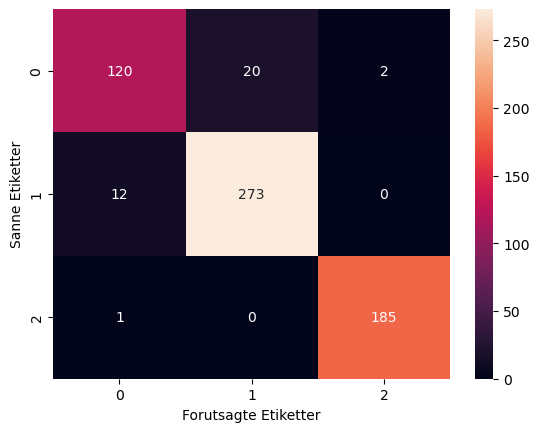

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Forutsi etikettene på valideringssettet
val_predictions = model.predict(X_val)
val_predicted_labels = np.argmax(val_predictions, axis=1)

# Beregn forvirringsmatrisen
cm = confusion_matrix(y_val_adjusted, val_predicted_labels)

# Vis forvirringsmatrisen
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Forutsagte Etiketter')
plt.ylabel('Sanne Etiketter')
plt.show()


Resultatene fra forvirringsmatrisen viser at den anvendte modellen har en god evne til å klassifisere de ulike klassene, med spesielt høy nøyaktighet for Klasse 1 og Klasse 2. Klasse 0 blir oftest korrekt identifisert, men det er en merkbar tendens til forveksling med Klasse 1. På den annen side blir Klasse 1 og Klasse 2 nesten alltid riktig identifisert, med svært få feilidentifikasjoner. Samlet sett indikerer disse resultatene at modellen er effektiv, men det kan være rom for forbedring spesielt i differensieringen mellom Klasse 0 og Klasse 1.

# Test av modell

In [19]:
def load_and_preprocess_images(directory, target_size=(128, 128)):
    images = []
    labels = []

    for label, class_name in enumerate(['meningioma', 'glioma', 'pituitary']):
        class_dir = os.path.join(directory, class_name)
        for image_file in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_file)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                image = cv2.resize(image, target_size)
                images.append(image)
                labels.append(label)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels


In [20]:
import cv2
from tensorflow.keras.utils import to_categorical

test_directory = 'C:/Users/simen/Prosjekter/archive/Testing' # Hardkodet som må endres lokalt
test_images, test_labels = load_and_preprocess_images(test_directory)

# Normaliser bildene
test_images = test_images / 255.0

# Konverter etiketter til kategoriske formatet
test_labels_categorical = to_categorical(test_labels)


In [21]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Testtap: {test_loss}, Testnøyaktighet: {test_accuracy}')

29/29 [==============================] - 4s 127ms/step - loss: 2.8594 - accuracy: 0.5541
Testtap: 2.8594412803649902, Testnøyaktighet: 0.5540838837623596


Resultatene fra testingen viser at modellen oppnådde en nøyaktighet på 55.41% med et tap (loss) på 2.8594. Dette indikerer at mens modellen har en viss evne til å klassifisere bildene korrekt, er det et betydelig rom for forbedring. En nøyaktighet på litt over halvparten tyder på at modellen ofte tar feil eller er usikker i sine prediksjoner. Det relativt høye tapet antyder også at det er betydelige avvik mellom modellens prediksjoner og de faktiske dataene. For å forbedre ytelsen, kan det være nødvendig å gjennomgå og justere modellarkitekturen, treningstilnærmingen, eller datamaterialet som brukes.